In [1]:
import numpy as np
import pandas as pd
import os
import yaml

from PIL import ImageColor

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter, LinearLocator
import matplotlib.patches as patches

import seaborn as sns
sns.set_style("ticks")
sns.set_context(context='paper',font_scale=1.2)
sns.despine()

%matplotlib inline
from matplotlib import rcParams

import warnings
warnings.filterwarnings('ignore')

#### Paths & Vars

In [2]:
# vars
tasks = ['mortality','longlos','invasivevent','sepsis']
metrics = ['auc','auprc','ace_abs_logistic_log']

# paths
figures_fpath = '/hpf/projects/lsung/projects/mimic4ds/Experiments/domain_adapt/figures/'
adapt_fpath = '/hpf/projects/lsung/projects/mimic4ds/Experiments/domain_adapt'
gen_fpath = '/hpf/projects/lsung/projects/mimic4ds/Experiments/domain_gen'
base_fpath = '/hpf/projects/lsung/projects/mimic4ds/Experiments/baseline'

### Collect Results

In [3]:
alpha = 0.05

results = {
    "base":{
        "eval":pd.read_csv(f"{base_fpath}/results/model_evaluation_{alpha}.csv").query("phase=='test'"),
        "compare":pd.read_csv(f"{base_fpath}/results/model_comparison_{alpha}.csv").query("phase=='test'"),
    },
    "gen":{
        "eval":pd.read_csv(f"{gen_fpath}/results/model_evaluation_{alpha}.csv").query("phase=='test' and `lambda`==-1 and group==1"),
        "compare":pd.read_csv(f"{gen_fpath}/results/model_comparison_{alpha}.csv").query("phase=='test' and `lambda`==-1 and group==1"),
    },
    "adapt":{
        "eval":pd.read_csv(f"{adapt_fpath}/results/model_evaluation_{alpha}.csv").query("phase=='test' and `lambda`==-1 and group==1"),
        "compare":pd.read_csv(f"{adapt_fpath}/results/model_comparison_{alpha}.csv").query("phase=='test' and `lambda`==-1 and group==1"),
    },
}

df_results_all = {}
for eval_method in ['avg', 'ensemble', 'best']:
    # base results
    df_base = results['base']['eval'].query(
        "\
        train_group=='2008 - 2010' and\
        eval_group=='2017 - 2019' and\
        evaluation_method==@eval_method and\
        metric==@metrics\
        "
    )[['analysis_id', 'metric', 'ci_lower','ci_med','ci_upper']]
    df_base['group']=1
    df_base['train_method']='Baseline [08-10]'

    # oracle results
    df_oracle = results['base']['eval'].query(
        "\
        train_group=='2017 - 2019' and\
        eval_group=='2017 - 2019' and\
        evaluation_method==@eval_method and\
        metric==@metrics\
        "
    )[['analysis_id', 'metric', 'ci_lower','ci_med','ci_upper']]
    df_oracle['group']=1
    df_oracle['train_method'] = 'Oracle [17-19]'

    # ERM results
    df_erm = results['gen']['eval'].query(
        "\
        train_method=='erm' and\
        evaluation_method==@eval_method and\
        metric==@metrics\
        "
    )[['analysis_id', 'metric', 'ci_lower','ci_med','ci_upper','group','train_method']]

    # domain gen results
    df_gen = results['gen']['eval'].query(
        "\
        train_method!='erm' and\
        evaluation_method==@eval_method and\
        metric==@metrics\
        "
    )[['analysis_id', 'metric', 'ci_lower','ci_med','ci_upper','group','train_method']]
    df_gen['framework'] = 'Domain Generalization'

    stats = results['gen']['compare'].query(
        "\
        evaluation_method==@eval_method and\
        metric==@metrics\
        "
    )[['analysis_id', 'metric', 'ci_lower','ci_upper','group','train_method']]
    stats['sig'] = stats['ci_lower']*stats['ci_upper']>0
    stats.drop(columns=['ci_lower','ci_upper'],inplace=True)

    df_gen = pd.merge(
        df_gen, 
        stats, 
        how='left', 
        left_on=['analysis_id','metric','group', 'train_method'],
        right_on = ['analysis_id','metric','group','train_method']
    )

    # domain adapt results
    df_adapt = results['adapt']['eval'].query(
        "\
        evaluation_method==@eval_method and\
        metric==@metrics\
        "
    )[['analysis_id', 'metric', 'ci_lower','ci_med','ci_upper','group','train_method','n_ood']]
    df_adapt['framework'] = 'Domain Adaptation'
    
    stats = results['adapt']['compare'].query(
        "\
        evaluation_method==@eval_method and\
        metric==@metrics\
        "
    )[['analysis_id', 'metric', 'ci_lower','ci_upper','group','train_method','n_ood']]
    stats['sig'] = stats['ci_lower']*stats['ci_upper']>0
    stats.drop(columns=['ci_lower','ci_upper'],inplace=True)

    df_adapt = pd.merge(
        df_adapt, 
        stats, 
        how='left', 
        left_on=['analysis_id','metric','group', 'train_method','n_ood'],
        right_on = ['analysis_id','metric','group','train_method','n_ood']
    )
    
    # join results
    df_results = pd.concat((df_base, df_oracle, df_erm, df_gen, df_adapt))
    
    # rename columns and values
    df_results.rename(columns = {
        'metric':'Metric',
        'group':'Year Group',
        'analysis_id':'Task',
        'n_ood':'Unlabeled OOD Samples',
        'framework': 'Framework',
        'train_method':'Method'},inplace=True)

    # Replace values
    df_results['Method'].replace(
        {
            'al_layer':"AL",
            'coral':"CORAL",
            'erm':"ERM",
            'irm':'IRM',
            'dro':'GroupDRO'
        },
        inplace=True
    )
    df_results['Task'].replace(
        {
            'longlos':'Long LOS',
            'sepsis':'Sepsis',
            'mortality':'Mortality',
            'invasivevent':'Invasive Ventilation',
        },
        inplace=True
    )
    df_results.fillna('N/A',inplace=True)
    df_results_all[eval_method] = df_results

### Plot

In [4]:
# Figure settings
y_axis = {
    'Long LOS':{
        'auc':{
            'lim':[0.6, 0.75],
            'lim_rel':[-0.08, 0.08],
            'label':'AUROC'
        },
        'auprc':{
            'lim':[0.4, 0.7],
            'lim_rel':[-0.08, 0.08],
            'label':'AUPRC'
        },
        'ace_abs_logistic_log':{
            'lim':[-0.02, 0.1],
            'lim_rel':[-0.06, 0.06],
            'label':'Calibration'
        },
    },
    'Sepsis':{
        'auc':{
            'lim':[0.5, 0.8],
            'lim_rel':[-0.12, 0.12],
            'label':'AUROC'
        },
        'auprc':{
            'lim':[0.1, 0.4],
            'lim_rel':[-0.22, 0.22],
            'label':'AUPRC'
        },
        'ace_abs_logistic_log':{
            'lim':[-0.02, 0.1],
            'lim_rel':[-0.08, 0.08],
            'label':'Calibration'
        },
    },
    'Mortality':{
        'auc':{
            'lim':[0.8, 0.95],
            'lim_rel':[-0.1, 0.1],
            'label':'AUROC'
        },
        'auprc':{
            'lim':[0.3, 0.65],
            'lim_rel':[-0.18, 0.18],
            'label':'AUPRC'
        },
        'ace_abs_logistic_log':{
            'lim':[-0.02, 0.1],
            'lim_rel':[-0.06, 0.06],
            'label':'Calibration'
        },
    },
    'Invasive Ventilation':{
        'auc':{
            'lim':[0.8, 0.95],
            'lim_rel':[-0.06, 0.06],
            'label':'AUROC'
        },
        'auprc':{
            'lim':[0.5, 0.8],
            'lim_rel':[-0.12, 0.12],
            'label':'AUPRC'
        },
        'ace_abs_logistic_log':{
            'lim':[-0.02, 0.1],
            'lim_rel':[-0.06, 0.06],
            'label':'Calibration'
        },
    },
}
order = [
    'ERM',
    'IRMDomain Generalization',
    'GroupDRODomain Generalization',
    'ALDomain Generalization',
    'CORALDomain Generalization',
    'ALDomain Adaptation100.0',
    'ALDomain Adaptation500.0',
    'ALDomain Adaptation1000.0',
    'ALDomain Adaptation1500.0',
    'CORALDomain Adaptation100.0',
    'CORALDomain Adaptation500.0',
    'CORALDomain Adaptation1000.0',
    'CORALDomain Adaptation1500.0',
]
method_colors = [
    "#000000",#ERM
    "#3D84B8",#IRM
    "#0a4b78",#DRO,
    "#52307c",#AL,
    "#ff5353",#CORAL,
    "#663a82",#AL-100
    "#7c5295",#AL-500
    "#b491c8",#AL-1500
    "#ff6969",#CORAL-100
    "#ff7e7e",#CORAL-500
    "#ff9696",#CORAL-1500
]
method_colors_rgb = []
for color in method_colors:
    color_rgb = ImageColor.getcolor(color,'RGB')
    method_colors_rgb.append([x/255 for x in color_rgb])
method_colors_rgb = np.array(method_colors_rgb)

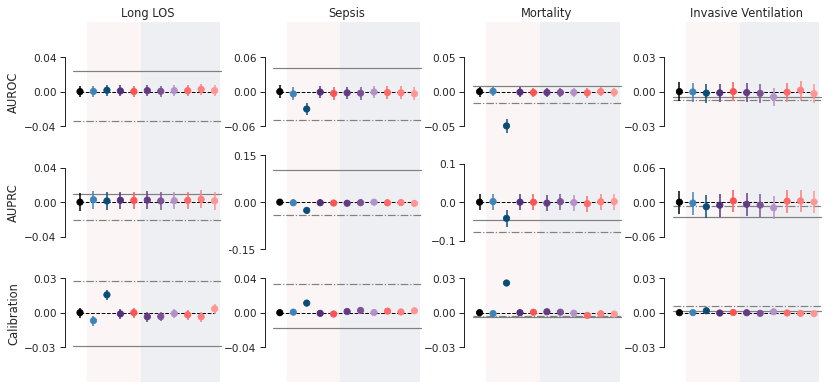

In [5]:
eval_method='avg'

rel_to_ERM = True

fig, axes = plt.subplots(
    nrows=len(metrics),
    ncols=len(tasks),
    figsize=(12,7)
)
plt.tight_layout(w_pad=0,h_pad=-5,rect=[0.05,0.15,1,0.95])
#plt.locator_params(axis='y', nbins=6)
for c,task in enumerate(['Long LOS','Sepsis','Mortality','Invasive Ventilation']):
    
    df_results = df_results_all[eval_method].query("Task==@task")
    df_results['Framework'].replace('N/A','',inplace=True)
    df_results['Unlabeled OOD Samples'].replace('N/A','',inplace=True)
    df_results['Method'] = df_results['Method'] + df_results['Framework'] + df_results['Unlabeled OOD Samples'].astype(str)

    for r,metric in enumerate(metrics):

            df = df_results.query(
                "\
                Metric==@metric and \
                Method!=['Baseline [08-10]','Oracle [17-19]']\
                ")[[
                'ci_lower','ci_med','ci_upper','Method'
            ]]
            
            df['ci_lower'] = (df['ci_lower'] - df['ci_med']).abs()
            df['ci_upper'] = (df['ci_upper'] - df['ci_med']).abs()
            
            df = df.set_index('Method').reindex([
                'ERM',
                'IRMDomain Generalization',
                'GroupDRODomain Generalization',
                'ALDomain Generalization',
                'CORALDomain Generalization',
                'ALDomain Adaptation100.0',
                'ALDomain Adaptation500.0',
                'ALDomain Adaptation1500.0',
                'CORALDomain Adaptation100.0',
                'CORALDomain Adaptation500.0',
                'CORALDomain Adaptation1500.0',
            ]).reset_index()

            df_08 = df_results.query(
                "\
                Method=='Baseline [08-10]' and \
                Metric==@metric\
                "
            )[['ci_lower','ci_med','ci_upper']]

            df_oracle = df_results.query(
                "\
                Method=='Oracle [17-19]' and \
                Metric==@metric\
                "
            )[['ci_lower','ci_med','ci_upper']]
            
            ref_val = df.loc[0,'ci_med']
            
            if rel_to_ERM:
                df['ci_med'] = df['ci_med'] - ref_val
                df_08['ci_med'] = df_08['ci_med'] - ref_val
                df_oracle['ci_med'] = df_oracle['ci_med'] - ref_val
                
            # plot bg patches for domain_gen
            rect = patches.Rectangle(
                (0.5,-1),
                4,
                20,
                linewidth=0.5,
                edgecolor='none',
                facecolor='#faf3f3',
                alpha=0.8,
                zorder=0
            )
            axes[r][c].add_patch(rect)
            
            # plot bg patches for domain_adapt
            rect = patches.Rectangle(
                (4.5,-1),
                5.9,
                20,
                linewidth=0.5,
                edgecolor='none',
                facecolor='#e1e5ea',
                alpha=0.6,
                zorder=0)
            
            axes[r][c].add_patch(rect)
            
            # plot reference line for baseline
            axes[r][c].plot(
                [-0.5,df.shape[0]-0.5],
                [df_08['ci_med'].values[0],df_08['ci_med'].values[0]],
                '-.',
                c = 'grey',
                zorder = 0,
            )
            
            # plot reference line for orcale
            axes[r][c].plot(
                [-0.5,df.shape[0]-0.5],
                [df_oracle['ci_med'].values[0],df_oracle['ci_med'].values[0]],
                '-',
                c = 'grey',
                zorder = 0,
            )
            
            # plot reference line for ERM
            axes[r][c].plot(
                [0,10],
                [df.loc[0,'ci_med'],df.loc[0,'ci_med']],
                linestyle = '--',
                linewidth = 1,
                color = 'black',
                zorder=0,
            )
            
            # plot model performance & error bars for DG & DA
            axes[r][c].scatter(
                df['Method'],
                df['ci_med'].values,
                s = 40,
                c = method_colors_rgb,
            )
            axes[r][c].errorbar(
                df['Method'],
                df['ci_med'].values,
                df[['ci_lower','ci_upper']].values.T,
                linestyle='',
                linewidth=1.5,
                c = method_colors_rgb,
            )
            

            ## Axes settings
            if rel_to_ERM:
                axes[r][c].set_ylim(y_axis[task][metric]['lim_rel'])
                #if r==0:
                #    axes[r][c].set_ylim([-0.1, 0.1])
                #elif r==1:
                #    axes[r][c].set_ylim([-0.18, 0.18])
                #elif r==2:
                #    axes[r][c].set_ylim([-0.06, 0.06])
            else:
                axes[r][c].set_ylim(y_axis[task][metric]['lim'])
            
            # grid
            axes[r][c].yaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
            #axes[r][c].grid(which='major', linewidth=0.5, axis='y')
            
            # x-ticks
            axes[r][c].set_xticklabels('')
            axes[r][c].set_xlabel('')
            axes[r][c].tick_params(axis='x', length=0)
            axes[r][c].spines['bottom'].set_color('white')
            
            # y ticks
            if c == 0:
                axes[r][c].set_ylabel(y_axis[task][metric]['label'])
                #axes[r][c].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            else:
                #axes[r][c].set_yticklabels('')
                axes[r][c].set_ylabel('')
                #axes[r][c].spines['left'].set_color('white')
                #axes[r][c].tick_params(axis='y', length=0)
                
            # title
            if r==0:
                axes[r][c].set_title(task)
            
            
                
sns.despine(offset=1, trim=True,)
plt.savefig(f"{figures_fpath}/ood_all.tif", dpi=300)
plt.show()